In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import datetime
from matplotlib import style
style.use('ggplot')
import math
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [37]:
df = pd.read_csv('C:/Users/Olatomiwa/Documents/SOL PLAATJE UNIVERSITY/HONOURS 2019/RESEARCH/From Supervisor Dr Mosia/first_yahoo_prices_volumes.csv')

In [38]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2014-09-10,19.680000,19.430000,19.650000,19.610001,4309400.0,18.881136
1,2014-09-11,19.540001,19.200001,19.469999,19.410000,6268000.0,18.688570
2,2014-09-12,19.530001,19.100000,19.530001,19.120001,6563400.0,18.409348
3,2014-09-15,19.209999,18.780001,19.180000,18.860001,7353800.0,18.159008
4,2014-09-16,19.240000,18.750000,18.809999,19.139999,5498400.0,18.428604


+ Checking the change after 7 dqys
+ Lag the data for past 7 days
+ Compare and map the target values
+ 1 = Gain; 0 = Fall;

In [39]:
def gain_fall(*args): # *args lets us pass any parameters, any number of arguments which becomes an iterable
    cols = [c for c in args] # passing each column mapping it row wise
    for col in cols:
        if(col > 0):
            return(1)   # GAIN
        if(col < 0):
            return(0)# FALL

In [40]:
df['1day_Lag'] = (df['Adj Close'].shift(-1) - df['Adj Close']) / df['Adj Close']
# .shift shifts up to get the future value old - new divided by 
        
df['1day_target'] = list(map(gain_fall, *[df['1day_Lag']]))

df['1day_target'] = df['1day_target'].shift(1)
df['1day_target'].fillna(0, inplace = True)
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,1day_Lag,1day_target
0,2014-09-10,19.680000,19.430000,19.650000,19.610001,4309400.0,18.881136,-0.010199,0.0
1,2014-09-11,19.540001,19.200001,19.469999,19.410000,6268000.0,18.688570,-0.014941,0.0
2,2014-09-12,19.530001,19.100000,19.530001,19.120001,6563400.0,18.409348,-0.013598,0.0
3,2014-09-15,19.209999,18.780001,19.180000,18.860001,7353800.0,18.159008,0.014846,1.0
4,2014-09-16,19.240000,18.750000,18.809999,19.139999,5498400.0,18.428604,0.000523,1.0


In [41]:
df['1day_target'] = df['1day_target'].shift(1)

In [42]:
df['1day_target'].head()

0    NaN
1    0.0
2    0.0
3    0.0
4    1.0
Name: 1day_target, dtype: float64

In [43]:
df['1day_target'].fillna(0, inplace = True)
df['1day_target'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: 1day_target, dtype: float64

In [44]:
# The distribution of the 1day_target mapping
vals = df['1day_target'].values #.tolist optional 
str_vals = [str(i) for i in vals]

print('Data spread: ', Counter(str_vals)) # seeing th way in which buys/sell/hold are distributed

Data spread:  Counter({'1.0': 584, '0.0': 497})


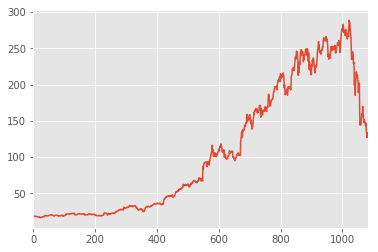

In [45]:
df['Adj Close'].plot()
plt.show()

In [46]:
# return of Adj price (Normalised by one day)
df_return = df['Adj Close'].pct_change()

In [47]:
df_return = df_return.replace([np.inf, -np.inf], np.nan) # replacing infinite changes with nan
df_return.dropna(inplace = True)

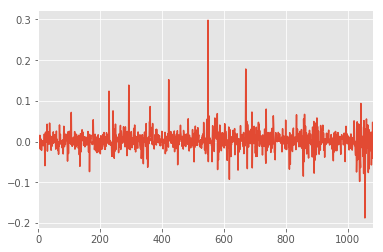

In [48]:
df_return.plot()
plt.show()

days = 7 # Number of days
for i in range(1, days + 1):
    #### Company name and days into the future
    df['{}day_Lag'.format(i)] = (df['Adj Close'].shift(-i) - df['Adj Close']) / df['Adj Close']
    #### .shift shifts up to get the future value old - new divided by 
        
    df['{}day_target'.format(i)] = list(map(gain_fall, *[df['{}day_Lag'.format(i)]for i in range(1, days+1)]))
    
df.fillna(0, inplace = True)
df.head()

In [49]:
data = {'x_features': df['Adj Close'].pct_change(),
                     'y_target': df['1day_target']}
frame = pd.DataFrame(data)

In [50]:
frame.dropna(inplace = True)

In [51]:
frame.head()

,x_features,y_target
1,-0.010199,0.0
2,-0.014941,0.0
3,-0.013598,0.0
4,0.014846,1.0
5,0.000523,1.0


## Neural Net (Deep) 2 hidden layers

In [52]:
# Required libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
import keras.backend as K

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [54]:
# Using train_test_fit to create subsets for fitting and testing
x_train, x_test, y_train, y_test = train_test_split(frame['x_features'], frame['y_target'], test_size = 0.3, random_state = 23, stratify = frame['y_target'])

In [55]:
model = Sequential([
    # Flattening the input Layer into a vector because it is a matrix
    Flatten(),
    
    #First hidden layer 
    Dense(256, activation = 'relu'), # or tf.nn.relu
    
    #to prevent overfitting
    Dropout(0.20),
    
    Dense(128, activation = 'relu'),
    
    Dropout(0.20),
    
    #output layer with 1 neuron with the sigmoid function to counter for the 2 classes (1 or 0)
    Dense(1, activation = 'sigmoid') # or tf.nn.softmax
       
])

In [56]:
#Compiler; using the adam optimizer and binary_crossentropy for binary classification
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [57]:
# Fitting the data; 10 iterations
model.fit(x_train.values, y_train.values, epochs = 20)

Epoch 1/20
756/756 [==============================] - 2s 2ms/sample - loss: 0.6749 - acc: 0.7698
Epoch 2/20
756/756 [==============================] - 0s 173us/sample - loss: 0.6270 - acc: 0.7857
Epoch 3/20
756/756 [==============================] - 0s 175us/sample - loss: 0.5590 - acc: 0.8347
Epoch 4/20
756/756 [==============================] - 0s 147us/sample - loss: 0.4738 - acc: 0.8717
Epoch 5/20
756/756 [==============================] - 0s 168us/sample - loss: 0.4023 - acc: 0.8810
Epoch 6/20
756/756 [==============================] - 0s 124us/sample - loss: 0.3225 - acc: 0.9206
Epoch 7/20
756/756 [==============================] - 0s 136us/sample - loss: 0.2795 - acc: 0.9220
Epoch 8/20
756/756 [==============================] - 0s 215us/sample - loss: 0.2316 - acc: 0.9511
Epoch 9/20
756/756 [==============================] - 0s 122us/sample - loss: 0.2075 - acc: 0.9299
Epoch 10/20
756/756 [==============================] - 0s 208us/sample - loss: 0.1840 - acc: 0.9669
Epoch 11/20

In [58]:
# Evaluating the test dataset
eval_array = model.evaluate(x_test, y_test)

print("\nTest Data Loss: {}".format(eval_array[0]))
print("\nTest Data Accuracy: {:.5}%".format(eval_array[1] * 100))

324/324 [==============================] - 0s 1ms/sample - loss: 0.0811 - acc: 0.9907

Test Data Loss: 0.08108309812751817

Test Data Accuracy: 99.074%


### Confusion Matrix 1

In [113]:
from pandas_ml import ConfusionMatrix as my_con

In [118]:
preds1 = model.predict(x_test)

array([[7.63973117e-01],
       [8.35388899e-04],
       [0.00000000e+00],
       [5.95918298e-03],
       [8.66903067e-01],
       [9.92367864e-01],
       [4.69177961e-04],
       [6.13311410e-01],
       [4.38392162e-05],
       [9.25572813e-02],
       [9.99992967e-01],
       [9.99998391e-01],
       [9.99125719e-01],
       [2.73883343e-05],
       [1.00000000e+00],
       [1.21593475e-04],
       [9.99943137e-01],
       [6.42538071e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.04928017e-03],
       [9.99972820e-01],
       [9.97770071e-01],
       [9.99967337e-01],
       [8.19057226e-04],
       [9.99999225e-01],
       [1.05217099e-03],
       [3.57627869e-06],
       [9.99987245e-01],
       [7.46164620e-02],
       [9.60549116e-01],
       [3.42607498e-03],
       [9.99992371e-01],
       [9.99576390e-01],
       [9.86895680e-01],
       [9.12431002e-01],
       [9.99996781e-01],
       [8.71834159e-02],
       [0.00000000e+00],
       [8.16661417e-02],


In [161]:
pd.crosstab(y_test, preds1 , rownames=['Actual'],colnames=['Predicted'], margins = True).ravel()

Exception: Data must be 1-dimensional

In [162]:
my_conf_matrix1 = my_con(y_test,model.predict(x_test)).ravel()
my_conf_matrix1

Exception: Data must be 1-dimensional

In [163]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds1).ravel()
print('tn:',tn, 'fp:',fp, 'fn:',fn, 'tp:',tp)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

### Model 2 MLP

In [59]:
model2 = Sequential([
    # Flattening the input Layer into a vector because it is a matrix
    Flatten(),
    
    Dense(128, activation = 'relu'),
    
    Dropout(0.20),
    
    #output layer with 1 neuron with the sigmoid function to counter for the 2 classes (1 or 0)
    Dense(1, activation = 'sigmoid') # or tf.nn.softmax
       
])

In [60]:
#Compiler; using the adam optimizer and binary_crossentropy for binary classification
model2.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [61]:
# Fitting the data; 10 iterations
model2.fit(x_train.values, y_train.values, epochs = 20)

Epoch 1/20
756/756 [==============================] - 0s 290us/sample - loss: 0.6865 - acc: 0.7765
Epoch 2/20
756/756 [==============================] - 0s 83us/sample - loss: 0.6810 - acc: 0.5780
Epoch 3/20
756/756 [==============================] - 0s 94us/sample - loss: 0.6757 - acc: 0.5675
Epoch 4/20
756/756 [==============================] - 0s 91us/sample - loss: 0.6712 - acc: 0.5648
Epoch 5/20
756/756 [==============================] - 0s 86us/sample - loss: 0.6680 - acc: 0.6217
Epoch 6/20
756/756 [==============================] - 0s 91us/sample - loss: 0.6608 - acc: 0.5741
Epoch 7/20
756/756 [==============================] - 0s 90us/sample - loss: 0.6544 - acc: 0.7077
Epoch 8/20
756/756 [==============================] - 0s 79us/sample - loss: 0.6452 - acc: 0.6614
Epoch 9/20
756/756 [==============================] - 0s 98us/sample - loss: 0.6375 - acc: 0.6376
Epoch 10/20
756/756 [==============================] - 0s 95us/sample - loss: 0.6273 - acc: 0.7513
Epoch 11/20
756/75

In [62]:
# Evaluating the test dataset
eval_array2 = model2.evaluate(x_test, y_test)

print("\nTest Data Loss: {}".format(eval_array2[0]))
print("\nTest Data Accuracy: {:.5}%".format(eval_array2[1] * 100))

324/324 [==============================] - 0s 176us/sample - loss: 0.5001 - acc: 0.9012

Test Data Loss: 0.5001140420819506

Test Data Accuracy: 90.123%


### Confusion Matrix 2

In [ ]:
pd.crosstab(y_pred_actual['y_actual'], y_pred_actual['y_predicted'], rownames=['Actual'],colnames=['Predicted'], margins = True)

In [ ]:
my_conf_matrix2 = my_con(y_pred_actual['y_actual'],y_pred_actual['y_predicted'])
my_conf_matrix2

In [63]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, cross_validation, preprocessing

In [64]:
df.isna().any()

Date           False
High           False
Low            False
Open           False
Close          False
Volume         False
Adj Close      False
1day_Lag       False
1day_target    False
dtype: bool

### 10 Fold Cross Validation Neural Net (Deep)

In [101]:
X = df.iloc[:, [1, 2, 3, 4, 5, 6]]

In [66]:
#X = X.replace([np.inf, -np.inf], np.nan)
#X.fillna(0, inplace = True)

In [67]:
y = df['1day_target']

In [68]:
y = y.replace([np.inf, -np.inf], np.nan)
y.fillna(0, inplace = True)

In [69]:
SEED = 23

XEncoded = encoder.transform(X)

#### model 1

In [157]:
axx = []
mean_auc = 0.0
n = 10  # repeat the CV procedure 10 times to get more precise results
for i in range(n):
    # for each iteration, randomly hold out 20% of the data as CV set
    X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(frame['x_features'], frame['y_target'], test_size=.20, random_state=i*SEED)

    # train model and make predictions
    model.fit(X_train, y_train) 
    preds = model.predict_proba(X_cv)
    evals = model.evaluate(X_cv, y_cv)
    axx.append(evals[1] * 100)

    # compute AUC metric for this CV fold
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, preds)
    roc_auc = metrics.auc(fpr, tpr)
    print("AUC (fold %d/%d): %f"%(i + 1, n, roc_auc))
    mean_auc += roc_auc

print("Mean AUC: %f"%(mean_auc/n))
print(axx)

216/216 [==============================] - 0s 1ms/sample - loss: 0.0207 - acc: 0.9954
AUC (fold 1/10): 1.000000
216/216 [==============================] - 0s 105us/sample - loss: 0.0219 - acc: 1.0000
AUC (fold 2/10): 1.000000
216/216 [==============================] - 0s 68us/sample - loss: 0.0176 - acc: 1.0000
AUC (fold 3/10): 1.000000
216/216 [==============================] - 0s 0s/sample - loss: 0.0187 - acc: 0.9954
AUC (fold 4/10): 1.000000
216/216 [==============================] - 0s 79us/sample - loss: 0.0273 - acc: 0.9907
AUC (fold 5/10): 1.000000
216/216 [==============================] - 0s 93us/sample - loss: 0.0171 - acc: 1.0000
AUC (fold 6/10): 1.000000
216/216 [==============================] - 0s 51us/sample - loss: 0.0260 - acc: 0.9861
AUC (fold 7/10): 1.000000
216/216 [==============================] - 0s 75us/sample - loss: 0.0119 - acc: 0.9954
AUC (fold 8/10): 1.000000
216/216 [==============================] - 0s 163us/sample - loss: 0.0216 - acc: 0.9954
AUC (fold 

### Model 2

In [146]:
axx2 = []
mean_auc = 0.0
n = 10  # repeat the CV procedure 10 times to get more precise results
for i in range(n):
    # for each iteration, randomly hold out 20% of the data as CV set
    X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(frame['x_features'], frame['y_target'], test_size=.20, random_state=i*SEED)

    # train model and make predictions
    model2.fit(X_train, y_train) 
    preds = model2.predict_proba(X_cv)
    evals = model2.evaluate(X_cv, y_cv)
    axx2.append(evals[1] * 100)

    # compute AUC metric for this CV fold
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, preds)
    roc_auc = metrics.auc(fpr, tpr)
    print("AUC (fold %d/%d): %f"%(i + 1, n, roc_auc))
    mean_auc += roc_auc

print("Mean AUC: %f"%(mean_auc/n))
print(axx2)

216/216 [==============================] - 0s 65us/sample - loss: 0.0979 - acc: 0.9861
AUC (fold 1/10): 1.000000
216/216 [==============================] - 0s 125us/sample - loss: 0.1005 - acc: 0.9954
AUC (fold 2/10): 1.000000
216/216 [==============================] - 0s 74us/sample - loss: 0.0981 - acc: 0.9815
AUC (fold 3/10): 1.000000
216/216 [==============================] - 0s 65us/sample - loss: 0.0907 - acc: 0.9954
AUC (fold 4/10): 1.000000
216/216 [==============================] - 0s 42us/sample - loss: 0.1207 - acc: 0.9907
AUC (fold 5/10): 1.000000
216/216 [==============================] - 0s 162us/sample - loss: 0.1146 - acc: 0.9815
AUC (fold 6/10): 1.000000
216/216 [==============================] - 0s 116us/sample - loss: 0.1042 - acc: 0.9861
AUC (fold 7/10): 1.000000
216/216 [==============================] - 0s 93us/sample - loss: 0.0844 - acc: 1.0000
AUC (fold 8/10): 1.000000
216/216 [==============================] - 0s 51us/sample - loss: 0.1123 - acc: 0.9907
AUC (f

### Logistic Regression 

In [158]:
clf= LogisticRegression()

### 10 fold cross Validation LR

In [159]:
axx3 = []
mean_auc = 0.0
n = 10  # repeat the CV procedure 10 times to get more precise results
for i in range(n):
    # for each iteration, randomly hold out 20% of the data as CV set
    X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(df[['Adj Close']], df['1day_target'], test_size=.20, random_state=i*SEED)

    # train model and make predictions
    clf.fit(X_train, y_train) 
    preds = clf.predict_proba(X_cv)[:, 1]

    # compute AUC metric for this CV fold
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, preds)
    roc_auc = metrics.auc(fpr, tpr)
    axx3.append(roc_auc)
    print("AUC (fold %d/%d): %f"%(i + 1, n, roc_auc))
    mean_auc += roc_auc

print("Mean AUC: %f"%(mean_auc/n))

AUC (fold 1/10): 0.434228
AUC (fold 2/10): 0.506330
AUC (fold 3/10): 0.444734
AUC (fold 4/10): 0.493248
AUC (fold 5/10): 0.470126
AUC (fold 6/10): 0.440634
AUC (fold 7/10): 0.487676
AUC (fold 8/10): 0.478879
AUC (fold 9/10): 0.448831
AUC (fold 10/10): 0.489153
Mean AUC: 0.469384
